## Compare the functions of dissimilarity on basic stacking models

### Libraries importation

In [1]:
import time
import os
import math
import csv
import importlib
from pathlib import Path
import numpy as np
import pinard as pn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

from pinard import utils
from pinard import preprocessing as pp

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import RidgeCV, LinearRegression
from xgboost import XGBRegressor
from itertools import combinations
from dissimilarity_functions import *


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

### Importation of the datasets

In [ ]:
# Function to load a CSV file with automatic separator detection

def load_csv_auto_sep(mode, data_source, type_data, verbose=True):
 
    # Regression: 'BeerOriginalExtract' or 'Digest_0.8' or 'YamProtein' //
    # Classification: 'CoffeeSpecies' or 'Malaria2024' or 'mDigest_custom3' or 'WhiskyConcentration' or 'YamMould'

    ## Importation of the datasets with the adapted path
    file_name = Path("Data/%s/%s"% (mode,data_source))
    full_path = str(file_name.resolve()).replace("\\", "/")
    path = full_path + "/%s.csv" % type_data

    with open(path, 'r', newline='', encoding='utf-8') as f:
        # Read a small portion of the file to detect the separator
        excerpt = f.read(1024)
        f.seek(0)  # return to the beginning of the file

        # Detection of the dialect
        dialect = csv.Sniffer().sniff(excerpt)
        sep = dialect.delimiter

        if verbose: print("Detected separator : %s" % sep)
        
        # Load the file with pandas
        df = pd.read_csv(f, delimiter=sep)

        if len(df.columns) > 1:
            # Drop the useless column if it exists
            df = df.drop(columns=[df.columns[1]])
        
        return df

In [96]:
mode = 'Regression'
data_source = 'YamProtein'

Xcal = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Xcal')
Xval = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Xval')
Ycal = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Ycal')
Yval = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Yval')

print("Number of spectra for calibration: ", len(Ycal))
print("Number of spectra for test: ", len(Yval))
display(Xcal.head(5))

Detected separator : ;
Detected separator : ;
Detected separator : 
Detected separator : 
Number of spectra for calibration:  784
Number of spectra for test:  248


,V1,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1041,V1042,V1043,V1044,V1045,V1046,V1047,V1048,V1049,V1050
0,0.163048,0.173601,0.178055,0.181673,0.184674,0.187279,0.189404,0.190971,0.192225,0.193210,...,0.728563,0.730664,0.732373,0.733608,0.734403,0.734922,0.735155,0.735095,0.734736,0.734165
1,0.159370,0.169495,0.173999,0.177437,0.180028,0.182533,0.184882,0.186467,0.187515,0.188330,...,0.720091,0.722194,0.723811,0.725038,0.725865,0.726412,0.726530,0.726389,0.726011,0.725416
2,0.163048,0.173601,0.178055,0.181673,0.184674,0.187279,0.189404,0.190971,0.192225,0.193210,...,0.728563,0.730664,0.732373,0.733608,0.734403,0.734922,0.735155,0.735095,0.734736,0.734165
3,0.159370,0.169495,0.173999,0.177437,0.180028,0.182533,0.184882,0.186467,0.187515,0.188330,...,0.720091,0.722194,0.723811,0.725038,0.725865,0.726412,0.726530,0.726389,0.726011,0.725416
4,0.148814,0.157951,0.161528,0.164204,0.166344,0.168472,0.170332,0.171494,0.172274,0.172794,...,0.717764,0.719747,0.721370,0.722661,0.723523,0.724061,0.724311,0.724114,0.723626,0.723033


In [97]:
rd_seed = 42
rd_seed = np.random.seed(rd_seed)

x = pd.concat([Xcal, Xval], axis=0).values
y = pd.concat([Ycal, Yval], axis=0).values

### Selection of the preprocessing methods

In [98]:
# Dictionnary of preprocessing methods that we want to apply

preprocessings = {
    'Savitzky-Golay (0)': pp.SavitzkyGolay(),
    'Savitzky-Golay (1)': pp.SavitzkyGolay(deriv=1),
    'Savitzky-Golay (2)': pp.SavitzkyGolay(deriv=2),
    'Savitzky-Golay (3)': pp.SavitzkyGolay(deriv=3),
    'Savitzky-Golay (4)': pp.SavitzkyGolay(deriv=4),
    'Savitzky-Golay (5)': pp.SavitzkyGolay(deriv=5),
    'Savitzky-Golay (6)': pp.SavitzkyGolay(deriv=6),
    'Gaussian (1, 2)': pp.Gaussian(order = 1, sigma = 2),
    'Gaussian (2, 1)': pp.Gaussian(order = 2, sigma = 1),
    'Gaussian (3, 1)': pp.Gaussian(order = 3, sigma = 1),
    'Gaussian (4, 1)': pp.Gaussian(order = 4, sigma = 1),
    'Gaussian (5, 1)': pp.Gaussian(order = 5, sigma = 1)
}

## Remove the preprocessing methods in an optimal way

We want to remove preprocessing methods so that it keeps the maximum possible number of them, still respecting the comparison obtained with the dissimilarity function.  

It actually is a classic problem in graph theory: the **minimum vertex cover problem** on an undirected graph, specifically where each pair represents an edge.

- Each preprocessing method is a **node**,
- Each couple is an **edge** between two nodes,
- We aim to find a minimum vertex cover, i.e. a set of nodes that every edge is incident to at least one node in the set.

For a bipartite graph, there are efficient algorithms to solve this optimally, for instance in the *networkx* package. It gives an **approximation of the optimal solution** but is still very close from optimal or optimal. To get the exact solution, one needs using linear programming, which might be computationnally heavy.

### Compare stacking models for diverse dissimilarity functions

In [99]:
dissim = importlib.import_module('dissimilarity_functions')
importlib.reload(dissim)

# dictionary of the dissimilarity functions to use
dict_dissim = {
    "KS test": dissim.dissim_KS,
    "Meta attributes": dissim.dissim_meta_att_var,
}

# dictionary of the time taken to compute the dissimilarity functions
dict_times = {'All preprocessings': 0}

# dictionary of preprocessing lists, in function of the dissimilarity function
dict_preprocessings = {'All preprocessings':[(k,v) for k,v in preprocessings.items()]}

for name, dissim_func in dict_dissim.items():
    print(f"Computing {name} dissimilarity...", end = '\r')

    normalize_dissim = True if name == "Meta attributes" else False

    # Determine the preprocessing methods to remove based on the dissimilarity function
    start_time = time.time()
    list_to_remove = dissim.preprocessings_to_remove_approx(preprocessings, x, distance_fn=dissim_func, normalize_dissim=normalize_dissim, threshold=("proportion", 0.1), verbose=True)
    elapsed_time = time.time() - start_time

    copy_dict = preprocessings.copy()
    # Remove it from the preprocessing methods
    for method in list_to_remove:
        del copy_dict[method]
    
    # Add the new list of preprocessing methods to the dictionary
    dict_preprocessings[name] = [(k,v) for k,v in copy_dict.items()]
    dict_times[name] = elapsed_time

del copy_dict

List of preprocessing methods to remove for dissim_KS: {'Gaussian (2, 1)', 'Savitzky-Golay (3)', 'Savitzky-Golay (5)', 'Savitzky-Golay (1)', 'Savitzky-Golay (2)', 'Savitzky-Golay (4)'}
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
List of preprocessing methods to remove for dissim_meta_att_var: {'Savitzky-Golay (5)', 'Savitzky-Golay (4)', 'Savitzky-Golay (0)'}
------------------------------------------------------------------------------------------------------------------------


### Creation of a pipeline for a stacking model

In [100]:
# Create a dictionary to store the scores for each similarity function
dict_scores = {} 

for name, preprocessings in dict_preprocessings.items():

    # create a pipeline that applies min-max scaling followed by preprocessing
    union_pipeline = make_pipeline(MinMaxScaler(), FeatureUnion(preprocessings))

    # this function creates a pipeline that applies the union_pipeline followed by the regressor
    def get_estimator(regressor):
        pipeline = make_pipeline(union_pipeline, regressor)
        return TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

    # create a list of estimators to use in the stacking regressor, each one is a pipeline of the union_pipeline and a regressor
    estimators = [
        ("Linear Regression", get_estimator( LinearRegression() ) ),
        ("PLS", get_estimator( PLSRegression(n_components=10) ) ),
        ("PLS_small", get_estimator( PLSRegression(n_components=3) ) ),
        ("XGBoost", get_estimator( XGBRegressor() ) )
    ]

    # create the stacking regressor, using the list of estimators and a final regressor
    stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=rd_seed))

    # using cross_validate to get scores and elapsed time
    start_time = time.time()
    score = cross_validate(stacking_regressor, x, y, cv=4, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=2)
    elapsed_time = time.time() - start_time

    # store the scores in the dictionary
    dict_scores[name] = {
        f"$R^2$": score["test_r2"].mean(),
        "MAE": -score["test_neg_mean_absolute_error"].mean(),
        "Cross validation time": elapsed_time,
        "Compute dissimilarity time": dict_times[name],
    }

print(dict_scores)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 12.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  7.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


{'All preprocessings': {'$R^2$': np.float64(0.5598571435948906), 'MAE': np.float64(0.48725048553456324), 'Cross validation time': 752.061071395874, 'Compute dissimilarity time': 0}, 'KS test': {'$R^2$': np.float64(0.5581258751118897), 'MAE': np.float64(0.5010875992998481), 'Cross validation time': 419.376802444458, 'Compute dissimilarity time': 47.41138505935669}, 'Meta attributes': {'$R^2$': np.float64(0.5457381967349273), 'MAE': np.float64(0.4838918195441947), 'Cross validation time': 673.9272153377533, 'Compute dissimilarity time': 400.1437199115753}}


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 11.2min finished


### Plot and save the results in barplots

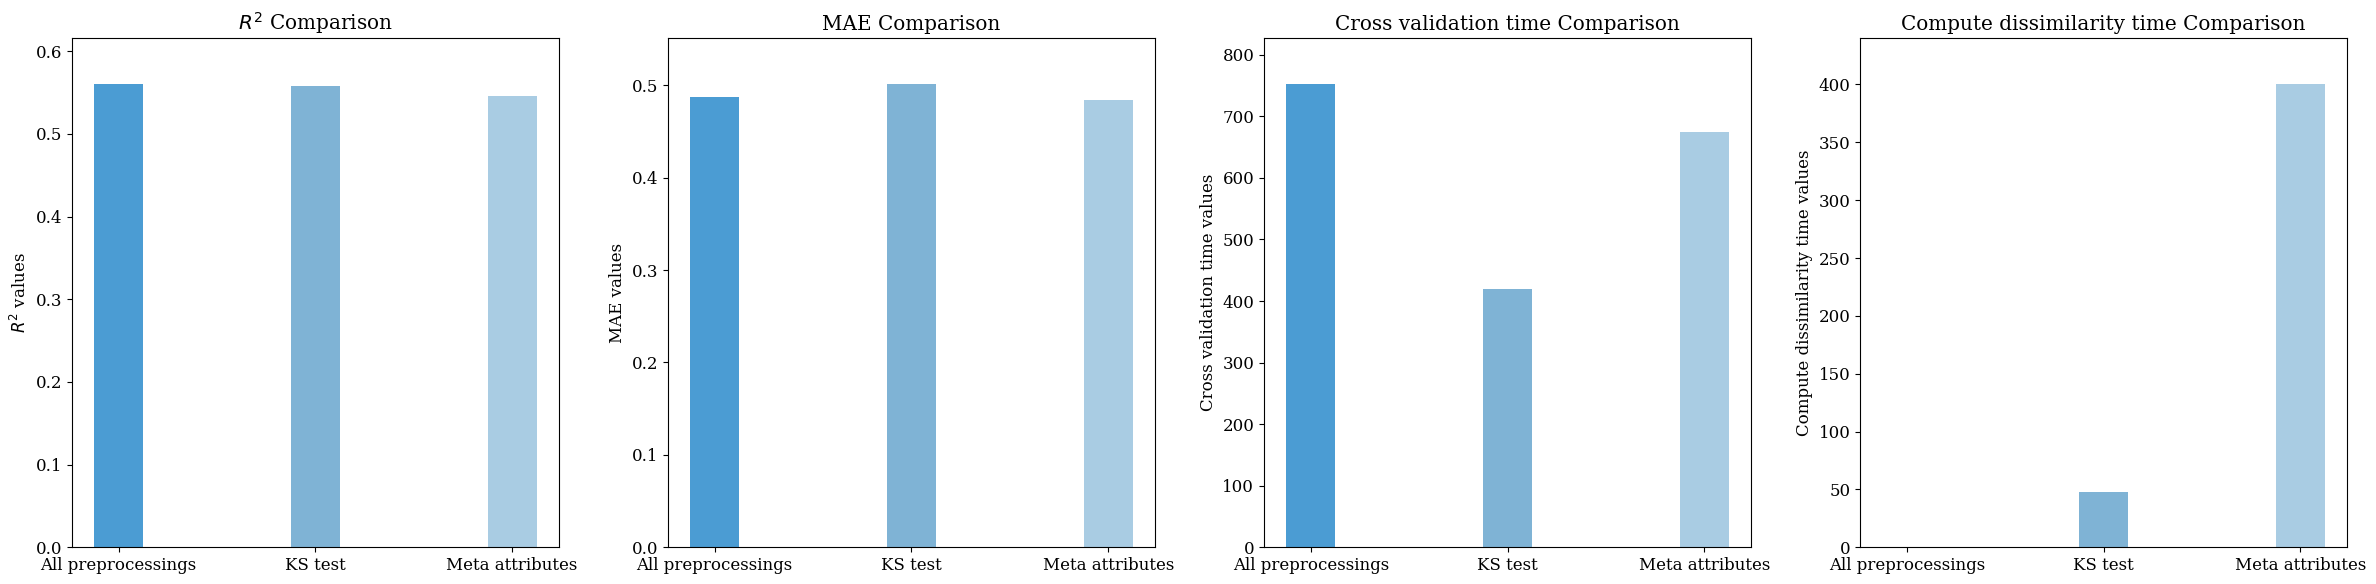

In [101]:
import matplotlib as mpl

# Create a new folder to save the figures
if not os.path.exists("Figures"):
    os.makedirs("Figures")
# Save the figure in the new folder
fig_path = os.path.join("Figures", "%s_comp_dissimilarity.png" % data_source)


# change the values from np.float64 to float
dict_scores = {key: {k: float(v) if k != 'time' else v for k, v in dico.items() } for key, dico in dict_scores.items()}

# Ravenclaw-style color palette (cool blues & greys)
colors = ['#4B9CD3', '#7FB3D5', '#A9CCE3', '#D6EAF8']

# Font setup
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12

criteria = list(dict_scores['All preprocessings'].keys())


method_A = list(dict_scores['All preprocessings'].values())
method_B = list(dict_scores['KS test'].values())
method_C = list(dict_scores['Meta attributes'].values())

# Bar width parameter
bar_width = 0.25

# Create a figure with three plots (1 line, 3 columns)
fig, axes = plt.subplots(1, len(criteria), figsize=(6 * len(criteria), 6))

for i, ax in enumerate(axes):
    values = [method_A[i], method_B[i], method_C[i]]
    n = len(values)
    x = np.arange(n)
    ax.set_ylim(0, 1.1 * max(values))  # Set the y-axis limits for all plots
    ax.bar(x, values, color = colors, width=bar_width, label=criteria[i])
    ax.set_xticks(x)
    ax.set_xticklabels(dict_scores.keys())
    ax.set_title(criteria[i] + " Comparison")
    ax.set_ylabel(criteria[i] + " values")

# Ajustement de la disposition
plt.tight_layout()
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
